In [41]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image
from tensorflow.keras import layers, models

#### Loading the dataset

In [12]:
data = os.listdir("../data/Digits" )
data_X = []     
data_y = []  
data_classes = len(data)
for i in range (0, data_classes):
    data_list = os.listdir("../data/Digits" +"/"+str(i))
    for j in data_list:
        pic = cv2.imread("../data/Digits" +"/"+str(i)+"/"+j)
        pic = cv2.resize(pic, (32, 32))
        data_X.append(pic)
        data_y.append(i)
if len(data_X) == len(data_y) :
    print("Total Dataponits = ",len(data_X))
data_X = np.array(data_X)
data_y = np.array(data_y)

Total Dataponits =  10160


In [13]:
train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.05)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)
print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (7721, 32, 32, 3)
Validation Set Shape =  (1931, 32, 32, 3)
Test Set Shape =  (508, 32, 32, 3)


#### Preprocessing

In [14]:
def Prep(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

In [15]:
train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))
#Reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)
#Augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

#### One hot encoding

In [16]:
train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)

#### Building the model

In [42]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

In [43]:
history = model.fit(train_X, train_y, epochs=10, validation_data=(valid_X, valid_y))

Epoch 1/10
242/242 [==============================] - 11s 30ms/step - loss: 0.4667 - accuracy: 0.8592 - val_loss: 0.0901 - val_accuracy: 0.9772
Epoch 2/10
242/242 [==============================] - 7s 28ms/step - loss: 0.0692 - accuracy: 0.9780 - val_loss: 0.0518 - val_accuracy: 0.9824
Epoch 3/10
242/242 [==============================] - 6s 26ms/step - loss: 0.0331 - accuracy: 0.9886 - val_loss: 0.0332 - val_accuracy: 0.9902
Epoch 4/10
242/242 [==============================] - 7s 29ms/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 0.0383 - val_accuracy: 0.9881
Epoch 5/10
242/242 [==============================] - 7s 27ms/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.0321 - val_accuracy: 0.9876
Epoch 6/10
242/242 [==============================] - 6s 25ms/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 0.0180 - val_accuracy: 0.9953
Epoch 7/10
242/242 [==============================] - 6s 23ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0189 - val_accuracy: 0.994

In [48]:
test_loss, test_acc = model.evaluate(test_X, test_y)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

16/16 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 1.0000
Test Loss: 0.006061351392418146
Test Accuracy: 1.0


#### Reading sudoku from an image

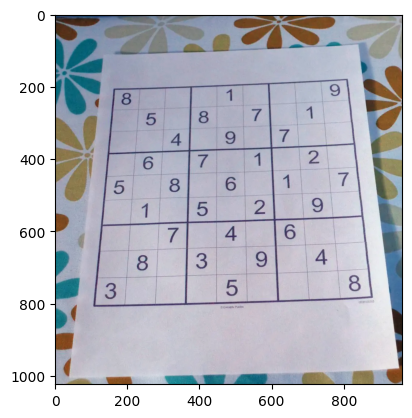

In [53]:
folder="../data/sudoku_imgs"
sudoku_a = cv2.imread(folder+'/'+ 'sud.jpg')
plt.figure()
plt.imshow(sudoku_a)
plt.show()

#### Preprocessing the image for further analysis

In [73]:
sudoku_a = cv2.resize(sudoku_a, (450,450))
# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

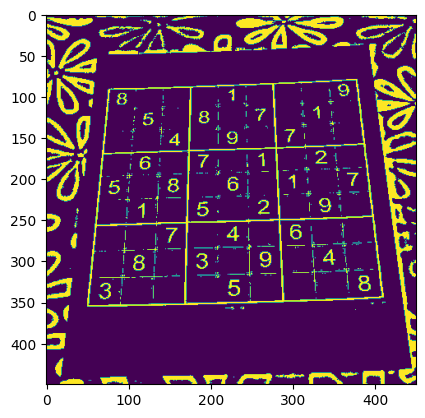

In [74]:
threshold = preprocess(sudoku_a)
plt.figure()
plt.imshow(threshold)
plt.show()

#### Contour detection

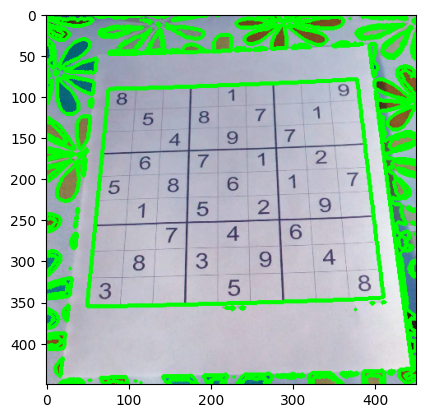

In [76]:
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour, -1, (0, 255, 0), 3)

plt.figure()
plt.imshow(contour_1)
plt.show()

#### Getting the well aligned grid

In [110]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

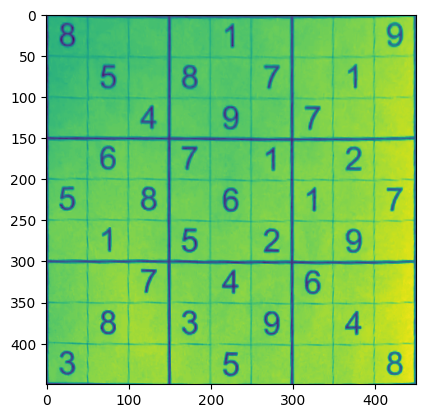

In [111]:
black_img = np.zeros((450, 450, 3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
cv2.drawContours(contour_2,biggest, -1, (0,255,0),10)
pts1 = np.float32(biggest)
pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450, 450))
imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(imagewrap)
plt.show()

#### Check another image

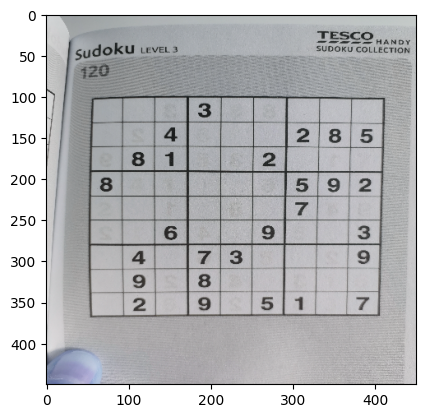

In [112]:
puzzle = cv2.imread("../data/sudoku_imgs/1.jpg")
puzzle = cv2.resize(puzzle, (450,450))
plt.figure()
plt.imshow(puzzle)
plt.show()

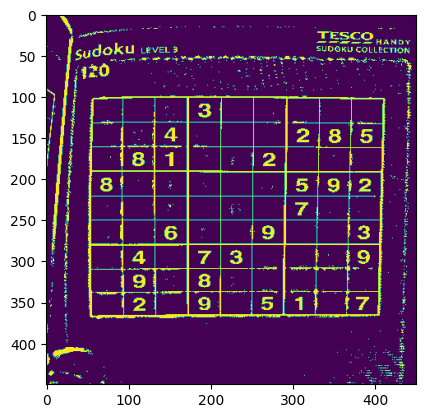

In [113]:
su_threshold = preprocess(puzzle)
plt.figure()
plt.imshow(su_threshold)
plt.show()

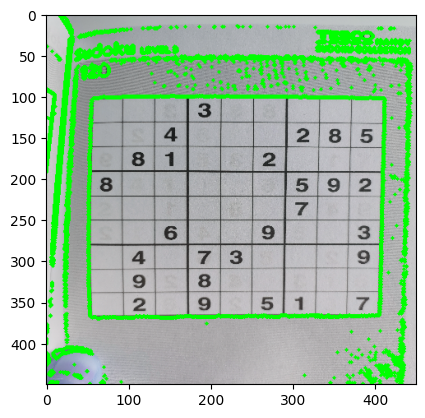

In [114]:
su_contour_1 = puzzle.copy()
su_contour_2 = sudoku_a.copy()
su_contour, su_hierarchy = cv2.findContours(su_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour, -1, (0, 255, 0), 3)

plt.figure()
plt.imshow(su_contour_1)
plt.show()

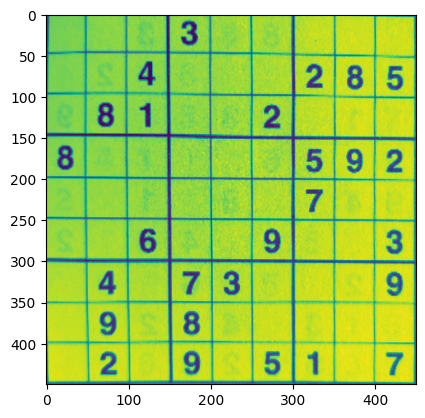

In [136]:
black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
su_pts1 = np.float32(su_biggest)
su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)  
su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

#### Classifying each digits after splitting each cells

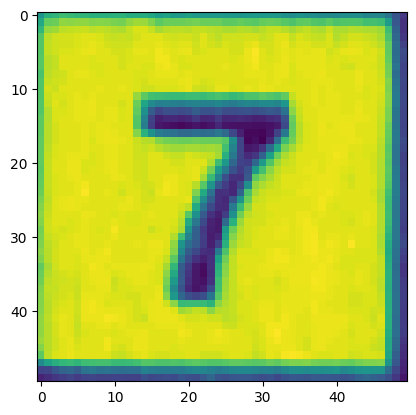

In [165]:
sudoku_cell = splitcells(su_imagewrap)
plt.figure()
plt.imshow(sudoku_cell[80])
plt.show()

In [146]:
def CropCell(cells):
    Cells_croped = []
    for image in cells:
        img = np.array(image)
        img = img[6:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
    return Cells_croped

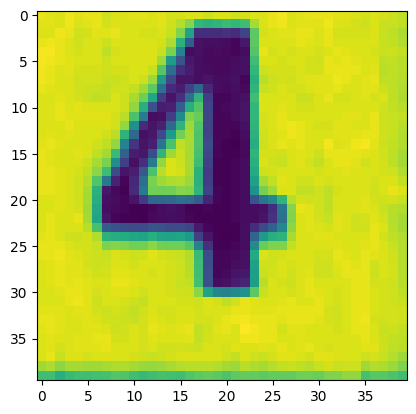

In [188]:
sudoku_cell_croped = CropCell(sudoku_cell)
plt.figure()
plt.imshow(sudoku_cell_croped[11])
plt.show()

In [189]:
new = []
for img in sudoku_cell_croped:
    img = np.array(img)
    img = cv2.resize(img, (32,32))
    new.append(img)

In [190]:
new[0].shape

(32, 32)

In [191]:
model.predict(new[11].reshape(1,32,32,1))

1/1 [==============================] - 0s 25ms/step


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

#### Sudoku solver using backtracking

In [196]:
def find_empty_cell(puzzle):
    for i in range(9):
        for j in range(9):
            if puzzle[i][j] == 0:
                return (i, j)
    return None

In [ ]:
def valid(puzzle, num, pos):
    # check row
    for i in range(9):
        if puzzle[pos[0]][i] == num and pos[1] != i:
            return False
    # check column
    for i in range(9):
        if puzzle[i][pos[1]] == num and pos[0] != i:
            return False
    # check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x*3, box_x*3 + 3):
            if puzzle[i][j] == num and (i, j) != pos:
                return False
    return True

In [197]:
def solve(puzzle):
    find = find_empty_cell(puzzle)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1, 10):
        if valid(puzzle, i, (row, col)):
            puzzle[row][col] = i
            if solve(puzzle):
                return True
            puzzle[row][col] = 0
    return False

In [198]:
def print_puzzle(puzzle):
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("-----------------------")
        for j in range(9):
            if j % 3 == 0 and j != 0:
                print("|", end="")
            if j == 8:
                print(puzzle[i][j])
            else:
                print(str(puzzle[i][j]) + " ", end="")
    return

In [199]:
def solve_sudoku(puzzle):
    print("Puzzle:")
    print_puzzle(puzzle)
    solve(puzzle)
    print("Solution:")
    print_puzzle(puzzle)
    return


In [200]:
puzzle = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9],
  ]
solve_sudoku(puzzle)

Puzzle:
5 3 0 |0 7 0 |0 0 0
6 0 0 |1 9 5 |0 0 0
0 9 8 |0 0 0 |0 6 0
-----------------------
8 0 0 |0 6 0 |0 0 3
4 0 0 |8 0 3 |0 0 1
7 0 0 |0 2 0 |0 0 6
-----------------------
0 6 0 |0 0 0 |2 8 0
0 0 0 |4 1 9 |0 0 5
0 0 0 |0 8 0 |0 7 9
Solution:
5 3 4 |6 7 8 |9 1 2
6 7 2 |1 9 5 |3 4 8
1 9 8 |3 4 2 |5 6 7
-----------------------
8 5 9 |7 6 1 |4 2 3
4 2 6 |8 5 3 |7 9 1
7 1 3 |9 2 4 |8 5 6
-----------------------
9 6 1 |5 3 7 |2 8 4
2 8 7 |4 1 9 |6 3 5
3 4 5 |2 8 6 |1 7 9
